In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate

In [5]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 12, 31)

Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Simulating a market

In [38]:
market = Market.garch().asfreq('BYS')

# Annualizing returns
#market.index = market.index.year

In [39]:
market

,data,volatility,errors,Price
2020-01-01,-0.458927,1.247598,-0.515312,1.000000e+02
2021-01-01,0.744024,0.997263,0.687638,1.110192e+02
2022-01-03,2.172992,0.631255,2.116607,1.052656e+02
2023-01-02,0.629737,0.774271,0.573351,1.400207e+02
2024-01-01,-0.298141,0.535475,-0.354526,1.579746e+02
...,...,...,...,...
2076-01-01,0.355175,0.650870,0.298790,1.548165e+06
2077-01-01,-0.600223,0.557991,-0.656608,1.700900e+06
2078-01-03,-0.497415,0.608674,-0.553801,1.913129e+06
2079-01-02,-0.910500,1.357486,-0.966885,3.920160e+06


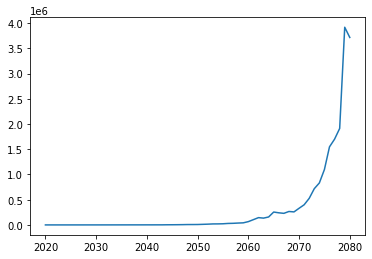

In [40]:
plt.plot(market['Price'])

## Setting up functions to calculate performance

In [226]:
def nd(s, pv_u, dst, td, cash, phase, g):
    # determine new debt dependent on phase
	# dont aquire debt or repay debt in phase 3 or 4
    if phase == 3 or phase == 4:
        return 0, s
    
    if phase == 1:
        new_debt = min(g*s, dst-pv_u+s)
        return (new_debt, s)
    
    if phase == 2: 
        debt_repayment = min(td, s)
        leftover_savings = max(s-debt_repayment, 0)
        return -debt_repayment, leftover_savings

In [255]:
def update_cash(phase, pv_u, tv_u, s, cash, pi):
    if phase == 1 or phase == 2:
        return 0, s
    
    if phase == 3:
        desired_cash = (1-pi)*(tv_u+s)
        print('des', desired_cash)
        new_cash = min(desired_cash, s)
        return (cash + new_cash), (s-new_cash)
    
    if phase == 4:
        desired_cash = (1-pi)*(tv_u+s)
        return desired_cash, -desired_cash

In [228]:
def phase_check(pv_u, dst, phase, td):
    if phase == 4:
        return 4
    
    if pv_u < dst and phase <= 2:
        return 1
    
    if td > 0 and pv_u >= dst:
        return 2
    
    if pv_u > dst:
        return 3
    else:
        return 4

## Combining with investment profile

In [213]:
savings = pd.read_csv('investment_plan.csv', sep=';', index_col=0)['Earnings'].values
market['Price'] = market['Price']*100/market['Price'].iloc[0]

In [267]:
pd.options.display.float_format = '{:20,.2f}'.format

In [268]:
def calculate_return(savings, market_returns, gearing_cap, pi, rf, rm):
    
    # Running controls
    print(len(savings), len(market))
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    total_savings = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi*total_savings
    
    columns = ['period', 'savings', 'cash', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat']
    
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    pp.is_copy = False 
        
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_debt'] = pp.loc[0, 'savings']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'savings']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm
    #pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']*(1+pp.loc[0, 'market_returns'])                      
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = pi*ist
    pp.loc[0, 'phase'] = 1                                   
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'pi_hat'] = pp.loc[i-1, 'pv_u']/pp.loc[i-1, 'tv_u']
        
        pp.loc[i, 'new_debt'], pp.loc[i, 'savings'] = nd(pp.loc[i, 'savings'], pp.loc[i-1, 'pv_u'], 
                                                         pp.loc[i-1, 'dst'], pp.loc[i-1, 'total_debt'],
                                                         pp.loc[i-1, 'cash'], pp.loc[i-1, 'phase'], gearing_cap)
        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        
        if i == 27:
            print(pp.loc[i, 'savings'])
        pp.loc[i, 'cash'], pp.loc[i, 'savings'] = update_cash(pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], pp.loc[i-1, 'tv_u'],
                                                                     pp.loc[i, 'savings'], pp.loc[i, 'cash'], pi)
        if i == 27:
            print(pp.loc[i, 'cash'], pp.loc[i, 'savings'])
        pp.loc[i, 'nip'] = pp.loc[i, 'savings'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'new_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        #pp.loc[i, 'dst'] = max(pp.loc[i, 'pv_u']*pi, pi*ist)  # Moving stock target
        pp.loc[i, 'dst'] = pi*ist  # Moving stock target
        pp.loc[i, 'phase'] = phase_check(pp.loc[i, 'pv_u'], pp.loc[i, 'dst'], pp.loc[i-1, 'phase'], pp.loc[i, 'total_debt'])


    return pp

In [269]:
investments = savings*0.05
port = calculate_return(investments, market['Price'].pct_change().values, 1, 0.9, 0.02, 0.03)

61 61
74669.2
des 1819388.730644937
74669.2 0.0
des 2389196.6942419764
des 3228512.2138800817
des 3308029.427499116
des 3647712.971195574
des 5070432.872207309
des 6564624.5687665045
des 8595336.0362911
des 8971410.190749958
des 9999622.346880296
des 12847187.874828381
des 13981221.598034108
des 16235521.252827272
des 18053048.594245564
des 28522000.87653135
des 45745711.1956096
des 62933759.24644218
des 58784546.40118132
des 68644947.26475127
des 111065497.91062848
des 104505796.32992014
des 99941796.07605867
des 115928355.0786875
des 112407323.61147909
des 143531685.0851867
des 173598354.87808454
des 228939977.59810433
des 312374213.01408696
des 361537490.8803561
des 477262734.20118636
des 672208148.6291682
des 738500312.1685437
des 830607219.8083291
des 1701492213.188261


In [270]:
port[20:30]

,period,savings,cash,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,dst,phase,pi_hat
20,20,0.00,0.00,"-53,066.00","319,229.80",0.00,"4,880,362.23",0.00,0.21,"5,908,051.93","5,908,051.93","3,879,846.38",2.00,1.00
21,21,0.00,0.00,"-55,719.20","263,510.60",0.00,"5,908,051.93",0.00,-0.13,"5,158,366.12","5,158,366.12","3,879,846.38",2.00,1.00
22,22,0.00,0.00,"-58,505.20","205,005.40",0.00,"5,158,366.12",0.00,0.34,"6,919,135.83","6,919,135.83","3,879,846.38",2.00,1.00
23,23,0.00,0.00,"-61,430.40","143,575.00",0.00,"6,919,135.83",0.00,0.01,"6,957,737.50","6,957,737.50","3,879,846.38",2.00,1.00
24,24,0.00,0.00,"-64,502.00","79,073.00",0.00,"6,957,737.50",0.00,0.80,"12,557,498.82","12,557,498.82","3,879,846.38",2.00,1.00
25,25,0.00,0.00,"-67,727.00","11,346.00",0.00,"12,557,498.82",0.00,0.16,"14,521,418.05","14,521,418.05","3,879,846.38",2.00,1.00
26,26,"59,767.40",0.00,"-11,346.00",0.00,"59,767.40","14,581,185.45",0.00,0.24,"18,119,218.11","18,119,218.11","3,879,846.38",3.00,1.00
27,27,0.00,"74,669.20",0.00,0.00,0.00,"18,119,218.11",0.00,0.31,"23,738,895.14","23,813,564.34","3,879,846.38",3.00,1.00
28,28,0.00,"154,565.18",0.00,0.00,0.00,"23,738,895.14",0.00,0.35,"32,048,234.15","32,202,799.34","3,879,846.38",3.00,1.00
29,29,0.00,"239,979.29",0.00,0.00,0.00,"32,048,234.15",0.00,0.02,"32,753,876.19","32,993,855.47","3,879,846.38",3.00,1.00


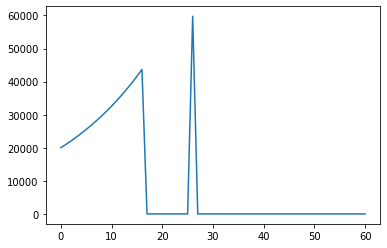

In [247]:
plt.plot(port['savings'])

array([        nan,  0.11019198, -0.05182563,  0.33016664,  0.12822298,
       -0.01214007,  0.22235145,  0.19878926,  0.57556003,  0.05806064,
       -0.01731138,  0.29827354,  0.13401547,  0.16471863,  0.13042628,
        0.19175438,  0.09651797,  0.21912213,  0.01639894, -0.03950829,
        0.21057652, -0.12689222,  0.34134252,  0.00557897,  0.80482503,
        0.15639414,  0.24264369,  0.31015009,  0.35003057,  0.02201813,
        0.10079036,  0.39176859,  0.29559894,  0.3105714 ,  0.04269178,
        0.11425887,  0.28624333,  0.08789933,  0.16165865,  0.11200807,
        0.58419938,  0.6070433 ,  0.37695223, -0.06639935,  0.16809769,
        0.61987885, -0.05934588, -0.04394598,  0.16024957, -0.03060089,
        0.27752746,  0.20984982,  0.31934361,  0.36495447,  0.15752481,
        0.32040437,  0.40879376,  0.09865574,  0.12477417,  1.04908328,
       -0.05173127])

<ipython-input-145-eceebd34809c>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale('log')


Text(0.5, 1.0, 'Portfolio contributions')

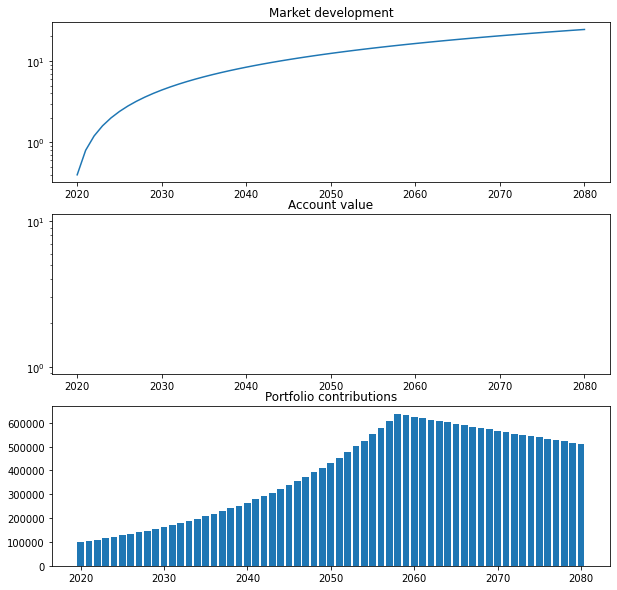

In [145]:
fig,ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(port['Price'])
ax[0].set_title('Market development')
ax[0].set_yscale('log')
ax[1].plot(port['Dollar_return'])
ax[1].set_title('Account value')
ax[1].set_yscale('log')
ax[2].bar(height=port['Contributions'], x=port.index)
ax[2].set_title('Portfolio contributions')